In [1]:
import jax
import jax.numpy as jnp
import flax.linen as nn
from src import dataio, visualize, evaluate

In [2]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

/tmp/ipykernel_83957/1991717721.py:2: DeprecationWarning: jax.lib.xla_bridge.get_backend is deprecated and will be removed in JAX v0.8.0; use jax.extend.backend.get_backend.
  print(xla_bridge.get_backend().platform)


gpu


  0%|          | 0/60000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [00:00<00:00, 27420.10it/s]


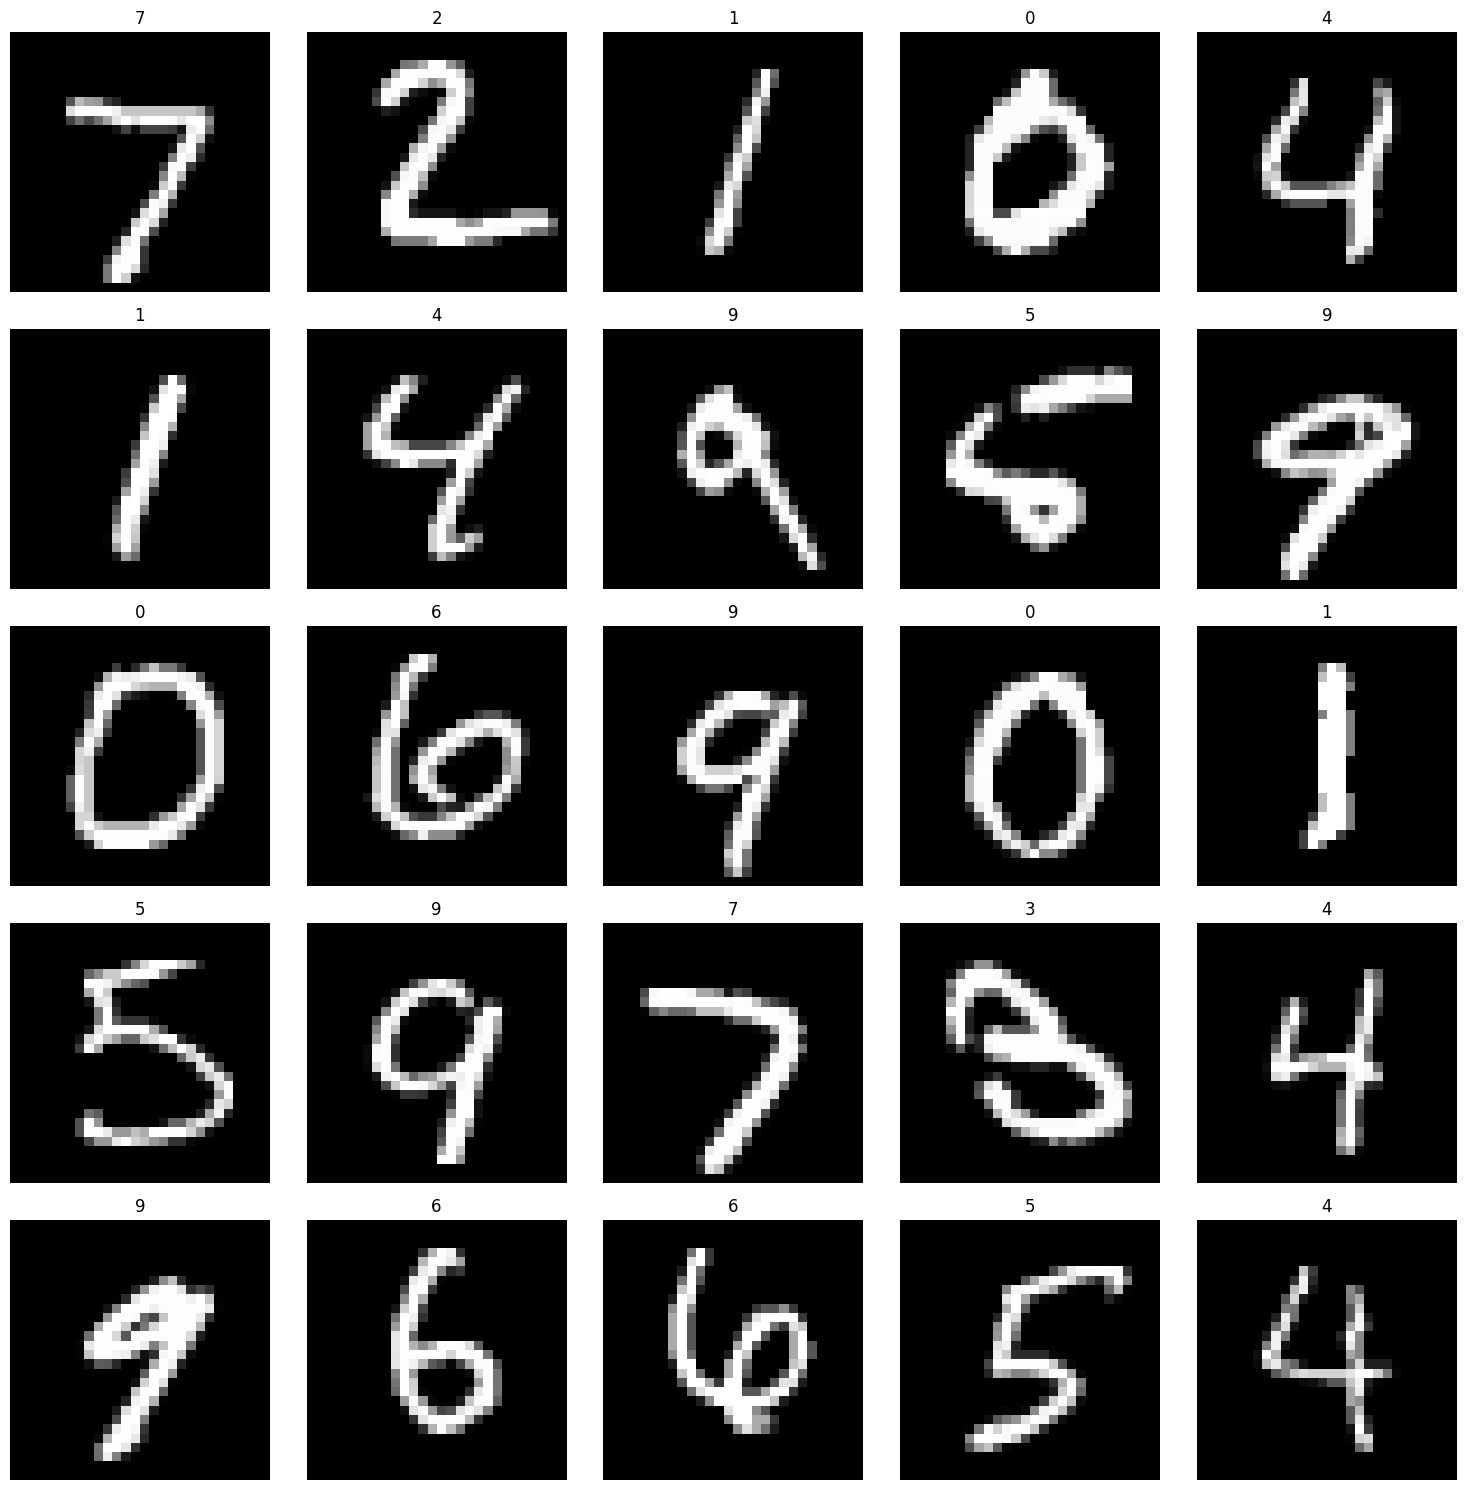

In [3]:
# データセットの読み込み
df_train, images_train = dataio.read_data('../dataset/train')
df_test, images_test = dataio.read_data('../dataset/test')
visualize.plot_images(images_test[:25], df_test, ncols=5, figsize=(15, 15))

In [4]:
class CNN(nn.Module):
    """シンプルなCNNモデル"""
    
    @nn.compact
    def __call__(self, x: jnp.ndarray) -> jnp.ndarray:
        """CNNモデルの順伝播

        Parameters
        ----------
        x : jnp.ndarray
            入力データ, shape: (b, 28, 28, 1)

        Returns
        -------
        jnp.ndarray
            出力データ, shape: (b, 10)
        """
        # 第1畳み込み層: 32フィルタ, 3x3カーネル
        x = nn.Conv(features=32, kernel_size=(3, 3), padding='VALID')(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2), padding='VALID')
        # 第2畳み込み層: 64フィルタ, 3x3カーネル
        x = nn.Conv(features=64, kernel_size=(3, 3), padding='VALID')(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2), padding='VALID')
        # 全結合層への入力のために1次元にフラット化
        x = x.reshape((x.shape[0], -1))
        
        # 全結合層: 256ユニット
        x = nn.Dense(features=256)(x)
        x = nn.relu(x)
        
        # 出力層: 10クラス (MNISTの0-9)
        x = nn.Dense(features=10)(x)
        return x

In [5]:
images_test.shape

(10000, 28, 28)

In [6]:
cnn = CNN()
print(cnn.tabulate(jax.random.key(0), jnp.ones((1, 28, 28, 1)),
                   ))


                                  CNN Summary                                   
┏━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ path    ┃ module ┃ inputs            ┃ outputs           ┃ params            ┃
┡━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│         │ CNN    │ float32[1,28,28,… │ float32[1,10]     │                   │
├─────────┼────────┼───────────────────┼───────────────────┼───────────────────┤
│ Conv_0  │ Conv   │ float32[1,28,28,… │ float32[1,26,26,… │ bias: float32[32] │
│         │        │                   │                   │ kernel:           │
│         │        │                   │                   │ float32[3,3,1,32] │
│         │        │                   │                   │                   │
│         │        │                   │                   │ 320 (1.3 KB)      │
├─────────┼────────┼───────────────────┼───────────────────┼───────────────────┤
│ Conv_1  │ Conv   │ float3

In [7]:
from clu import metrics
from flax.training import train_state  # モデルパラメータなど学習に関する値を保持
from flax import struct                # JAXでで扱うためのdataclass
import optax                           # loss関数やoptimizerが定義されている

@struct.dataclass
class Metrics(metrics.Collection):
    accuracy: metrics.Accuracy
    '''精度'''
    loss: metrics.Average.from_output('loss') # type: ignore
    '''ロス'''
  
class TrainState(train_state.TrainState):
    metrics: Metrics
    '''指標'''

def create_train_state(module: nn.Module, rng: jnp.ndarray, learning_rate: float, momentum: float) -> train_state.TrainState:
    """`TrainState`を作成する関数

    Parameters
    ----------
    module : nn.Module
        モデル
    rng : jnp.ndarray
        乱数用のパラメータ
    learning_rate : float
        学習率
    momentum : float
        モーメンタム

    Returns
    -------
    train_state.TrainState
        初期化された`TrainState`
    """
    params = module.init(rng, jnp.ones([1, 28, 28, 1], dtype=jnp.float32))['params'] # initialize parameters by passing a template image
    tx = optax.sgd(learning_rate, momentum)
    return TrainState.create(
        apply_fn=module.apply, params=params, tx=tx,
        metrics=Metrics.empty())

In [8]:
num_epochs = 5
batch_size = 25
num_steps_per_epoch = images_train.shape[0] // num_epochs
metrics_history = {'train_loss': [],
                   'train_accuracy': []}

In [9]:
# 学習済みモデルの読み込み
import orbax.checkpoint as ocp
import os

learning_rate = 0.01
momentum = 0.9
init_rng = jax.random.key(0)
state = create_train_state(cnn, init_rng, learning_rate, momentum)
del init_rng
abstract_state_tree = jax.tree_util.tree_map(ocp.utils.to_shape_dtype_struct, state)

dirpath = os.path.join(os.getcwd(), '..', 'weights', 'cnn-ckpt', 'step5')
checkpointer = ocp.StandardCheckpointer()
state = checkpointer.restore(dirpath, abstract_state_tree)

In [10]:
test_data = []
for i in range(0, images_test.shape[0], batch_size):
    test_data.append({
      'image': jnp.array(images_test[i:i + batch_size, ..., jnp.newaxis]) / 255.0,
      'label': jnp.array(df_test['label'][i:i + batch_size].values)
    })

In [ ]:

    
@jax.jit
def eval_step(state: train_state.TrainState, image: jnp.ndarray, label: jnp.ndarray) -> train_state.TrainState:
    """1ステップの評価を実行する関数

    Parameters
    ----------
    state : train_state.TrainState
        現在の学習状態
    image : jnp.ndarray
        入力画像, shape: (b, 28, 28, 1)
    label : jnp.ndarray
        正解ラベル, shape: (b,)

    Returns
    -------
    train_state.TrainState
        更新後の学習状態
    """
    print("コンパイル中: eval_step")
    logits = cnn.apply({'params': state.params}, image)
    return logits.argmax(axis=-1) == label


In [12]:
# warmup (compile)
_ = eval_step(state, jnp.zeros_like(test_data[0]['image']), jnp.zeros_like(test_data[0]['label']))

コンパイル中


In [13]:
def run(state):
    # 計測値をリセット
    state = state.replace(metrics=state.metrics.empty())
    results = []
    for step, batch in enumerate(test_data):
        ret = eval_step(state, batch['image'], batch['label'])  
        results += [ret]

    return jnp.hstack(results)

In [14]:
results = evaluate.measure_runtime(run, state=state)
print(f"accuracy: {results.mean() * 100}")


Runtime: 0.349121 seconds
accuracy: 98.87999725341797


# fori_loop版

In [ ]:
images_test_jax = jnp.array([data['image'] for data in test_data])
labels_test_jax = jnp.array([data['label'] for data in test_data])


@jax.jit
def run_fori_loop(state, images_test_jax, labels_test_jax):
    print("コンパイル中")
    # 計測値をリセット
    state = state.replace(metrics=state.metrics.empty())
    # 結果をこの配列に格納
    results = jnp.zeros_like(labels_test_jax, dtype=jnp.bool)
    def loop_fn(step: int, carry: tuple[jnp.ndarray, jnp.ndarray, jnp.ndarray]) -> tuple[jnp.ndarray, jnp.ndarray, jnp.ndarray]:
        """ループ処理関数

        Parameters
        ----------
        step : int
            現在のステップ
        carry : tuple[jnp.ndarray, jnp.ndarray, jnp.ndarray]
            (images_test_jax, labels_test_jax, results)のタプル

        Returns
        -------
        tuple[jnp.ndarray, jnp.ndarray, jnp.ndarray]
            更新された(images_test_jax, labels_test_jax, results)のタプル
        """
        # images_test_jax: shape = (s, b, 28, 28, 1)
        # labels_test_jax: shape = (s, b)
        # results: shape = (s, b)
        images_test_jax, labels_test_jax, results = carry
        ret = eval_step(state, images_test_jax.at[step].get(), labels_test_jax.at[step].get())
        results = results.at[step].set(ret)
        return (images_test_jax, labels_test_jax, results)
    images_test_jax, labels_test_jax, results = jax.lax.fori_loop(0, len(test_data), loop_fn, (images_test_jax, labels_test_jax, results))
    return results.flatten()

In [22]:
# warmup
# NOTE: images_test_jax/labels_test_jaxのshapeが変わると再コンパイルされるので注意
_ = run_fori_loop(state=state, images_test_jax=images_test_jax, labels_test_jax=labels_test_jax)

コンパイル中


In [34]:
results = evaluate.measure_runtime(run_fori_loop, state=state, images_test_jax=images_test_jax, labels_test_jax=labels_test_jax)
print(f"accuracy: {results.mean() * 100}")

Runtime: 0.025614 seconds
accuracy: 98.87999725341797


# Scan版

In [ ]:
# images_test_jax = jnp.array([data['image'] for data in test_data])
# labels_test_jax = jnp.array([data['label'] for data in test_data])


# @jax.jit
# def run_scan(state, images_test_jax, labels_test_jax):
#     print("コンパイル中")
#     # 計測値をリセット
#     state = state.replace(metrics=state.metrics.empty())
#     # 結果をこの配列に格納
#     results = jnp.zeros_like(labels_test_jax, dtype=jnp.bool)
#     def loop_fn(carry: tuple[jnp.ndarray, jnp.ndarray, jnp.ndarray], step: int) -> tuple[tuple[jnp.ndarray, jnp.ndarray, jnp.ndarray], None]:
#         """ループ処理関数

#         Parameters
#         ----------
#         carry : tuple[jnp.ndarray, jnp.ndarray, jnp.ndarray]
#             (images_test_jax, labels_test_jax, results)のタプル
#         step : int
#             現在のステップ

#         Returns
#         -------
#         tuple[jnp.ndarray, jnp.ndarray, jnp.ndarray]
#             更新された(images_test_jax, labels_test_jax, results)のタプル
#         """
#         images_test_jax, labels_test_jax, results = carry
#         ret = eval_step(state, images_test_jax.at[step].get(), labels_test_jax.at[step].get())
#         results = results.at[step].set(ret)
#         return (images_test_jax, labels_test_jax, results), None
#     (images_test_jax, labels_test_jax, results), _ = jax.lax.scan(loop_fn, (images_test_jax, labels_test_jax, results), jnp.arange(images_test_jax.shape[0]))
#     return results.flatten()

In [ ]:
images_test_jax = jnp.array([data['image'] for data in test_data])
labels_test_jax = jnp.array([data['label'] for data in test_data])


@jax.jit
def run_scan(state, images_test_jax, labels_test_jax):
    print("コンパイル中")
    # 計測値をリセット
    state = state.replace(metrics=state.metrics.empty())
    # 結果をこの配列に格納
    def loop_fn(carry: tuple[jnp.ndarray, jnp.ndarray, jnp.ndarray], step: int) -> tuple[tuple[jnp.ndarray, jnp.ndarray, jnp.ndarray], jnp.ndarray]:
        """ループ処理関数

        Parameters
        ----------
        carry : tuple[jnp.ndarray, jnp.ndarray]
            (images_test_jax, labels_test_jax)のタプル
        step : int
            現在のステップ

        Returns
        -------
        tuple[tuple[jnp.ndarray, jnp.ndarray, jnp.ndarray], jnp.ndarray]
            更新された(images_test_jax, labels_test_jax)のタプル
            評価結果配列（Scanの仕様で結合される）
        """
        images_test_jax, labels_test_jax = carry
        ret = eval_step(state, images_test_jax.at[step].get(), labels_test_jax.at[step].get())
        return (images_test_jax, labels_test_jax), ret
    (images_test_jax, labels_test_jax), results = jax.lax.scan(loop_fn, (images_test_jax, labels_test_jax), jnp.arange(images_test_jax.shape[0]))
    return results.flatten()

In [31]:
# warmup
# NOTE: images_test_jax/labels_test_jaxのshapeが変わると再コンパイルされるので注意
_ = run_scan(state=state, images_test_jax=images_test_jax, labels_test_jax=labels_test_jax)

コンパイル中


In [33]:
results = evaluate.measure_runtime(run_scan, state=state, images_test_jax=images_test_jax, labels_test_jax=labels_test_jax)
print(f"accuracy: {results.mean() * 100}")

Runtime: 0.023517 seconds
accuracy: 98.87999725341797


# vmap版

In [37]:
images_test_jax = jnp.array([data['image'] for data in test_data])
labels_test_jax = jnp.array([data['label'] for data in test_data])


@jax.jit
def run_vmap(state, images_test_jax, labels_test_jax):
    print("コンパイル中")
    # 計測値をリセット
    state = state.replace(metrics=state.metrics.empty())
    vmap_fn = jax.vmap(eval_step, (None, 0, 0), 0)
    results = vmap_fn(state, images_test_jax, labels_test_jax)
    return results

In [38]:
# warmup
# NOTE: images_test_jax/labels_test_jaxのshapeが変わると再コンパイルされるので注意
_ = run_vmap(state=state, images_test_jax=images_test_jax, labels_test_jax=labels_test_jax)

コンパイル中


2025-08-25 09:09:15.415375: W external/xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.35GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-08-25 09:09:15.491453: W external/xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.61GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-08-25 09:09:15.837285: W external/xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.91GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


In [39]:
results = evaluate.measure_runtime(run_vmap, state=state, images_test_jax=images_test_jax, labels_test_jax=labels_test_jax)
print(f"accuracy: {results.mean() * 100}")

Runtime: 0.001357 seconds
accuracy: 98.87999725341797
